# Modeling Realised Extractable Value
This notebook demonstrates two models that can be used to predict the realised extractable value (REV).

MEV is a theoretical quantity that can only be approached asymptotically. Extractions could happen off-chain or through other hard to trace paths. Hence, we will focus on the Realized Extractable Value (REV) instead, where REV ≤ MEV. In other words, REV is the actual value extracted from the blockchain from MEV opportunities.

REV is approximated by `block_net_profit`, which is calculated as the miner's balance change before and after mining a block, filtered to remove mining pool payout (tx originated from the miner), the static block rewards from PoW and the burnt fee.

The data used in this analysis is obtained post the London fork from block number `12965000` to `15229999`.

The following models are used in the attempt to estimate REV:
- Decision Tree Classifier
- Random Forest Regressor



In [2]:
#@title Load Packages & Functions{ run: "auto", vertical-output: true }

###################
## Load Packages ##
###################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import beta, gamma, pareto, poisson, nbinom
from scipy import stats
from functools import reduce
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, log_loss, precision_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
import graphviz
import warnings
warnings.filterwarnings('ignore')

####################
## Load Functions ##
####################
def format_date(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

def format_date_m(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M')

def format_date_ms(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S.%f')

def format_date_h(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H')

def format_date_d(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d')

def stationary_test(x):

    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')

def poisson(k, lamb): 
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def negative_log_likelihood(params, data):
    return -stats.poisson.logpmf(data, params[0]).sum()

def plot_cdf(data, var, lb, ub, increment, title):
    mybins = np.append(-np.inf, np.arange(lb, ub, increment))
    mybins = np.append(mybins, np.inf)
    mybins = np.round(mybins, 2)
    count, bins = np.histogram(data[var], bins=mybins)
    table = pd.DataFrame({'bin': bins[1:], 'count': count})
    table["pdf"] = table["count"] / sum(table["count"])
    table["cdf"] = np.cumsum(table["pdf"])
    
    # plotting CDF
    plt.plot(table['bin'], table["cdf"])
    plt.xlabel(var)
    plt.ylabel('Cumulative percentage')
    plt.title(title)
    
    return table

def aggregate_profit(data, var, profit_name):
    ## Cumulative distribution
    agg = pd.DataFrame(data.groupby(var).size()).reset_index().rename(columns={0:"count"})
    avg_profit = pd.DataFrame(data.groupby(var)[profit_name].mean()).reset_index().rename(columns={profit_name:"avg_block_net_profit"})
    med_profit = pd.DataFrame(data.groupby(var)[profit_name].median()).reset_index().rename(columns={profit_name:"median_block_net_profit"})
    total_profit = pd.DataFrame(data.groupby(var)[profit_name].sum()).reset_index().rename(columns={profit_name:"total_block_net_profit"})  
    agg = agg.merge(avg_profit, on = var, how = 'left')
    agg = agg.merge(med_profit, on = var, how = 'left')
    agg = agg.merge(total_profit, on = var, how = 'left')
    agg['count_perc'] = agg['count']/agg['count'].sum()
    agg['cum_count'] = agg['count'].cumsum()
    agg['cum_count_perc'] = agg['cum_count']/agg['count'].sum()
    agg['cum_avg_profit'] = agg['avg_block_net_profit'].cumsum()
    agg['cum_median_profit'] = agg['median_block_net_profit'].cumsum()
    agg['cum_total_profit'] = agg['total_block_net_profit'].cumsum()
    return(agg)


def get_confusion_matrix(cm, classes=None, title = 'Confusion Matrix'):
    if classes is not None:
        ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=100., annot=True, cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+0.5, top-0.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
    
    else:
        ax = sns.heatmap(cm, vmin=0., vmax=100., cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+1.5, top-1.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

def plot_confusion_matrix(y, y_hat, class_name, title, fontsize):
    sns.set(font_scale=fontsize)
    cm_train = confusion_matrix(y, y_hat)
    cm_norm_train = cm_train/cm_train.sum(axis=1)[:, np.newaxis]
    plt.figure()
    get_confusion_matrix(cm_norm_train*100, classes=class_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])

def model_performance(y, y_hat):
    print('Balanced Accuracy Score: ', np.round(balanced_accuracy_score(y, y_hat),2))
    print('Log Loss: ', np.round(log_loss(y, y_hat),2))
    out = precision_recall_fscore_support(y, y_hat, average='weighted')
    print('Precision: ', np.round(out[0],2))
    print('Recall: ', np.round(out[1],2))
    print('F-score: ', np.round(out[2],2))

def scatter_plot(x, y, cluster):
    fig, ax = plt.subplots()
    x_name = pd.DataFrame(x).columns.values[0]
    y_name = pd.DataFrame(y).columns.values[0]
    ax.scatter(x,y, c=cluster, label=np.unique(cluster))
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    
def sns_bar_plot(data, xvar, yvar, interval, title):
    plot = sns.barplot(data[xvar], data[yvar])
    for ind, label in enumerate(plot.get_xticklabels()):
        if ind % interval == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    plt.xticks(rotation=90)
    plt.title(title)
    
    
def equalbins(data, nbin):
    nlen = len(data)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(data))

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

def aggregate_to_hour(rev_data):
    data_h = pd.DataFrame(rev_data.groupby('datetime_h').size()).reset_index().rename(columns={0:"blocks_count"})
    avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['block_net_profit'].mean()).reset_index().rename(columns={"block_net_profit":"avg_block_net_profit"})
    med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['block_net_profit'].median()).reset_index().rename(columns={"block_net_profit":"median_block_net_profit"})
    nfb_avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_no_bundles'].mean()).reset_index().rename(columns={"profit_no_bundles":"avg_profit_no_bundles"})
    nfb_med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_no_bundles'].median()).reset_index().rename(columns={"profit_no_bundles":"median_profit_no_bundles"})
    bundle_avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_from_bundles'].mean()).reset_index().rename(columns={"profit_from_bundles":"avg_profit_from_bundles"})
    bundle_med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_from_bundles'].median()).reset_index().rename(columns={"profit_from_bundles":"median_profit_from_bundles"})
    gas_avg = pd.DataFrame(rev_data.groupby('datetime_h')['total_gas_used'].mean()).reset_index().rename(columns={"total_gas_used":"avg_total_gas_used"})
    gas_med = pd.DataFrame(rev_data.groupby('datetime_h')['total_gas_used'].median()).reset_index().rename(columns={"total_gas_used":"median_total_gas_used"})
    tail_avg = pd.DataFrame(rev_data.groupby('datetime_h')['tail_gas_price'].mean()).reset_index().rename(columns={"tail_gas_price":"avg_tail_gas_price"})
    tail_med = pd.DataFrame(rev_data.groupby('datetime_h')['tail_gas_price'].median()).reset_index().rename(columns={"tail_gas_price":"median_tail_gas_price"})
    bf_avg = pd.DataFrame(rev_data.groupby('datetime_h')['base_fee_per_gas'].mean()).reset_index().rename(columns={"base_fee_per_gas":"avg_base_fee_per_gas"})
    bf_med = pd.DataFrame(rev_data.groupby('datetime_h')['base_fee_per_gas'].median()).reset_index().rename(columns={"base_fee_per_gas":"median_base_fee_per_gas"})
    eth_avg = pd.DataFrame(rev_data.groupby('datetime_h')['eth_usd_price'].mean()).reset_index().rename(columns={"eth_usd_price":"avg_eth_usd_price"})
    eth_med = pd.DataFrame(rev_data.groupby('datetime_h')['eth_usd_price'].median()).reset_index().rename(columns={"eth_usd_price":"median_eth_usd_price"})
    time_avg = pd.DataFrame(rev_data.groupby('datetime_h')['block_time'].mean()).reset_index().rename(columns={"block_time":"avg_block_time"})
    time_med = pd.DataFrame(rev_data.groupby('datetime_h')['block_time'].median()).reset_index().rename(columns={"block_time":"median_block_time"})
    bundle_count = pd.DataFrame(rev_data.groupby('datetime_h')['bundles_dummy'].sum()).reset_index().rename(columns={"bundles_dummy":"fb_bundles_count"})
    
    data_h = data_h.merge(avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(nfb_avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(nfb_med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(gas_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(gas_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(tail_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(tail_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bf_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bf_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(eth_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(eth_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(time_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(time_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_count, on = "datetime_h", how = 'left')
    return data_h

def plot_feature_importance(model, feature_name = None, title = 'Feature Importance'):
  feature_importance = model.feature_importances_
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + .5
  fig = plt.figure(figsize=(12, 6))
  plt.barh(pos, feature_importance[sorted_idx], align='center')
  plt.yticks(pos, np.array(feature_name)[sorted_idx])
  plt.title(title)

def ts_performance(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    smape = 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))
    # me = np.mean(forecast - actual)             # ME
    # mae = np.mean(np.abs(forecast - actual))    # MAE
    # mpe = np.mean((forecast - actual)/actual)   # MPE
    # rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'Mean Absolute Percentage Error':mape, 'Correlation':corr, 'Symmetric Mean Absolute Error':smape})

  

In [3]:
######################
## Read in REV data ##
######################
rev_data = pd.read_csv('Data/clean_rev.csv')

## Sort data by block number
rev_data = rev_data.sort_values(by=['block_number'], ascending = True)


## 1. Block Net Profit (REV)
The cumulative distribution shows 80% of the blocks have a block net profit <= 0.25 ETH; 90% <=0.45ETH and 99% <= 2 ETH.


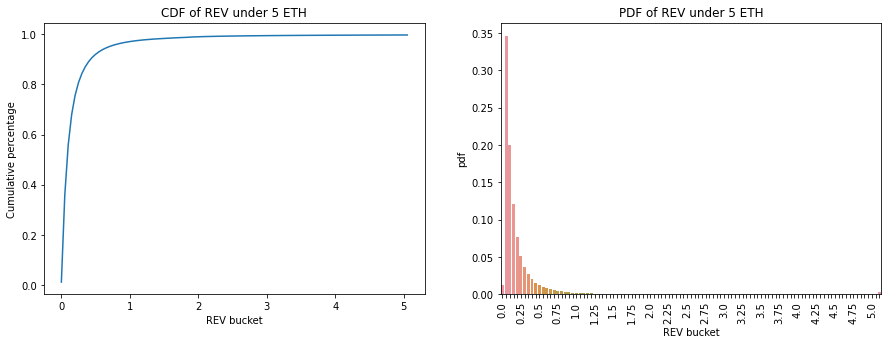

,bin,count,pdf,cdf
0,0.00,29280,0.012927,0.012927
1,0.05,784911,0.346539,0.359466
2,0.10,452119,0.199611,0.559077
3,0.15,273073,0.120562,0.679639
4,0.20,172882,0.076328,0.755967
...,...,...,...,...
98,4.90,76,0.000034,0.996937
99,4.95,79,0.000035,0.996972
100,5.00,80,0.000035,0.997007
101,5.05,73,0.000032,0.997039


In [8]:
#@title Distribution plot - up to 5 ETH
## Plot profit <= 5ETH
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1) 
freq_table_5=plot_cdf(data=rev_data, var='block_net_profit', lb=0, ub=5.1, increment=0.05, title='CDF of REV under 5 ETH')
plt.xlabel('REV bucket')
plt.subplot(1, 2, 2) 
sns_bar_plot(freq_table_5, 'bin', 'pdf', 5, 'PDF of REV under 5 ETH')
plt.xlabel('REV bucket')
plt.show()

freq_table_5

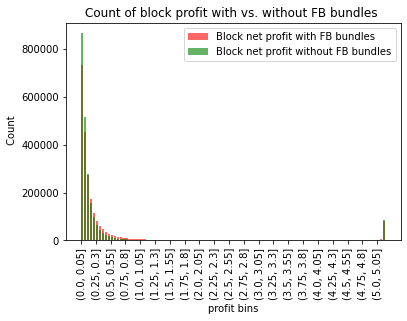

In [14]:
#@title Histogram FB vs. non-FB bundles - up to 5 ETH
rev_data['profit_bin'] = pd.cut(rev_data['block_net_profit'], right=True, bins=freq_table_5['bin']).astype(str)
rev_data['profit_non_FB_bin'] = pd.cut(rev_data['profit_no_bundles'], right=True, bins=freq_table_5['bin']).astype(str)

profit_agg = aggregate_profit(rev_data, 'profit_bin', 'block_net_profit')
profit_agg_nfb = aggregate_profit(rev_data, 'profit_non_FB_bin', 'block_net_profit')

plt.bar(profit_agg['profit_bin'], profit_agg["count"], color = 'r', label='Block net profit with FB bundles', alpha=0.6, align='edge')
plt.bar(profit_agg_nfb['profit_non_FB_bin'], profit_agg_nfb["count"], color = 'g', label='Block net profit without FB bundles', alpha=0.6, align='edge')
plt.xlabel("profit bins")
plt.ylabel(" Count")
plt.xticks(rotation = 90)
plt.xticks(np.arange(0, len(profit_agg), 5))
plt.title("Count of block profit with vs. without FB bundles ")
plt.legend()


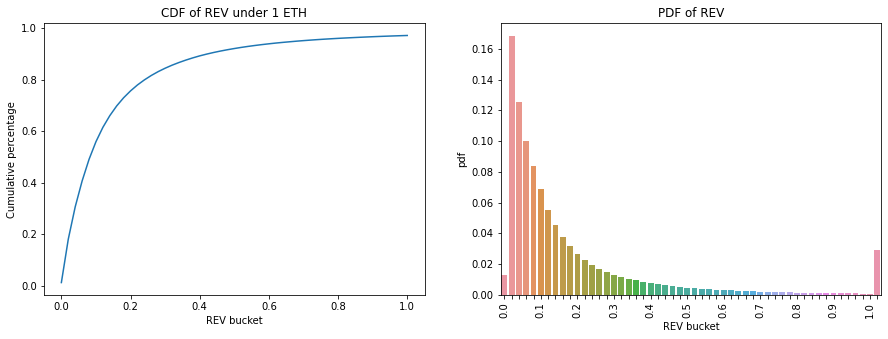

In [22]:
#@title Distribution plot - up to 1 ETH
## Plot profit <= 1ETH
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1) 
freq_table_1 = plot_cdf(data=rev_data, var='block_net_profit', lb=0, ub=1.02, increment=0.02, title='CDF of REV under 1 ETH')
plt.xlabel('REV bucket')
plt.subplot(1, 2, 2) 
sns_bar_plot(freq_table_1, 'bin', 'pdf', 5, 'PDF of REV')
plt.xlabel('REV bucket')
plt.show()



,bin,count,pdf,cdf
0,0.0,29280,0.012927,0.012927
1,0.1,1237030,0.546150,0.559077
2,0.2,445955,0.196890,0.755967
3,0.3,199126,0.087914,0.843881
4,0.4,108420,0.047868,0.891749
5,0.5,64418,0.028441,0.920189
6,0.6,41499,0.018322,0.938511
7,0.7,27943,0.012337,0.950848
8,0.8,19823,0.008752,0.959600
9,0.9,14472,0.006389,0.965989


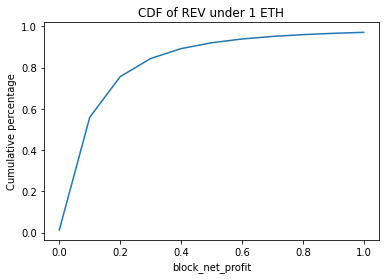

In [13]:
freq_table_01 = plot_cdf(data=rev_data, var='block_net_profit', lb=0, ub=1.1, increment=0.1, title='CDF of REV under 1 ETH')
freq_table_01

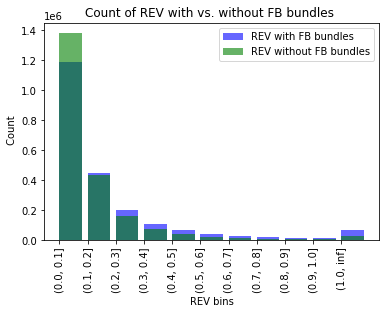

In [16]:
#@title Histogram FB vs. non-FB bundles - up to 1 ETH
rev_data['profit_bin_1'] = pd.cut(rev_data['block_net_profit'], right=True, bins=freq_table_01['bin']).astype(str)
rev_data['profit_non_FB_bin_1'] = pd.cut(rev_data['profit_no_bundles'], right=True, bins=freq_table_01['bin']).astype(str)

profit_agg_1 = aggregate_profit(rev_data, 'profit_bin_1', 'block_net_profit')[:-1]
profit_agg_nfb_1 = aggregate_profit(rev_data, 'profit_non_FB_bin_1', 'block_net_profit')[:-1]

plt.bar(profit_agg_1['profit_bin_1'], profit_agg_1["count"], color = 'b', label='REV with FB bundles', alpha=0.6, align='edge')
plt.bar(profit_agg_nfb_1['profit_non_FB_bin_1'], profit_agg_nfb_1["count"], color = 'g', label='REV without FB bundles', alpha=0.6, align='edge')
plt.xlabel("REV bins")
plt.ylabel(" Count")
plt.xticks(rotation = 90)
plt.title("Count of REV with vs. without FB bundles ")
plt.legend()



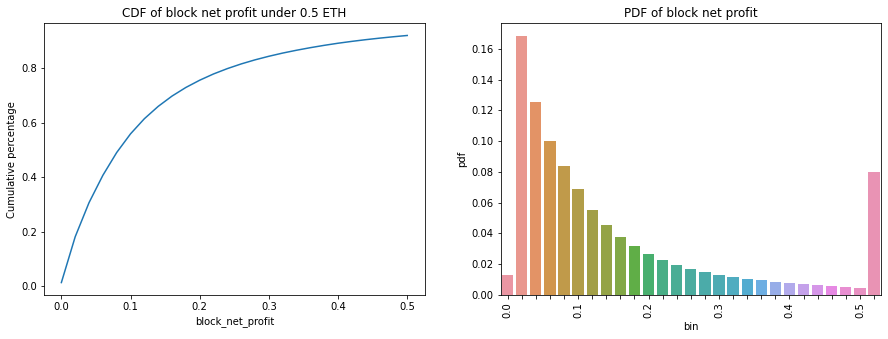

,bin,count,pdf,cdf
0,0.00,29280,0.012927,0.012927
1,0.02,381106,0.168259,0.181186
2,0.04,283672,0.125242,0.306427
3,0.06,227290,0.100349,0.406776
4,0.08,189705,0.083755,0.490531
5,0.10,155257,0.068546,0.559077
6,0.12,125748,0.055518,0.614595
7,0.14,102593,0.045295,0.659890
8,0.16,85780,0.037872,0.697762
9,0.18,71568,0.031597,0.729359


In [7]:
#@title Distribution plot profit <= 0.5 ETH
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1) 
freq_table_05 = plot_cdf(data=rev_data, var='block_net_profit', lb=0, ub=0.52, increment=0.02, title='CDF of block net profit under 0.5 ETH')
plt.subplot(1, 2, 2) 
sns_bar_plot(freq_table_05, 'bin', 'pdf', 5, 'PDF of block net profit')

plt.show()
freq_table_05

## 2. Block Time
The distribution shows 80% of the blocks have block time <= 22 seconds; 90% <= 32 seconds and 99% <= 61 seconds.

REV is aggregated to different time intervals to see if there is any seasonality in the data. The hourly chart shows REV is higher during UTC hour 14:00 to 20:00, which coincides with the New York Stock Exchange trading hours. The monthly chart shows August to November have higher REV than the other months. This is probably due to the boom periods in 2021.

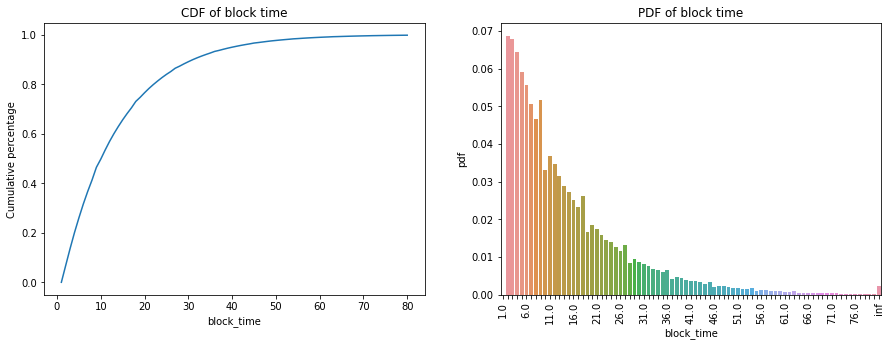

,bin,count,pdf,cdf
0,1.0,0,0.000000,0.000000
1,2.0,155596,0.068696,0.068696
2,3.0,153757,0.067884,0.136580
3,4.0,145555,0.064263,0.200842
4,5.0,133656,0.059009,0.259852
...,...,...,...,...
76,77.0,521,0.000230,0.997068
77,78.0,463,0.000204,0.997273
78,79.0,426,0.000188,0.997461
79,80.0,418,0.000185,0.997645


In [8]:
#@title Block time CDF & PDF plots
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1) 
freq_table_time = plot_cdf(data=rev_data, var='block_time', lb=1, ub=81, increment=1, title='CDF of block time')
plt.subplot(1, 2, 2) 
sns_bar_plot(freq_table_time, 'bin', 'pdf', 5, 'PDF of block time')
plt.xlabel('block_time')
plt.show()
freq_table_time

,bin,count,pdf,cdf
0,0.00,0,0.00,0.00
1,5.00,588564,0.26,0.26
2,10.00,537647,0.24,0.50
3,15.00,359376,0.16,0.66
4,20.00,247709,0.11,0.77
5,25.00,168106,0.07,0.84
6,30.00,115764,0.05,0.89
7,35.00,79375,0.04,0.93
8,40.00,53511,0.02,0.95
9,45.00,37829,0.02,0.97


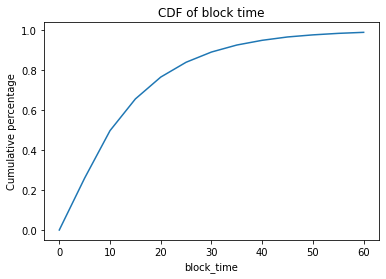

In [9]:
freq_table_time_60 = plot_cdf(data=rev_data, var='block_time', lb=0, ub=65, increment=5, title='CDF of block time')
pd.options.display.float_format = '{:,.2f}'.format
freq_table_time_60

Text(0, 0.5, 'REV')

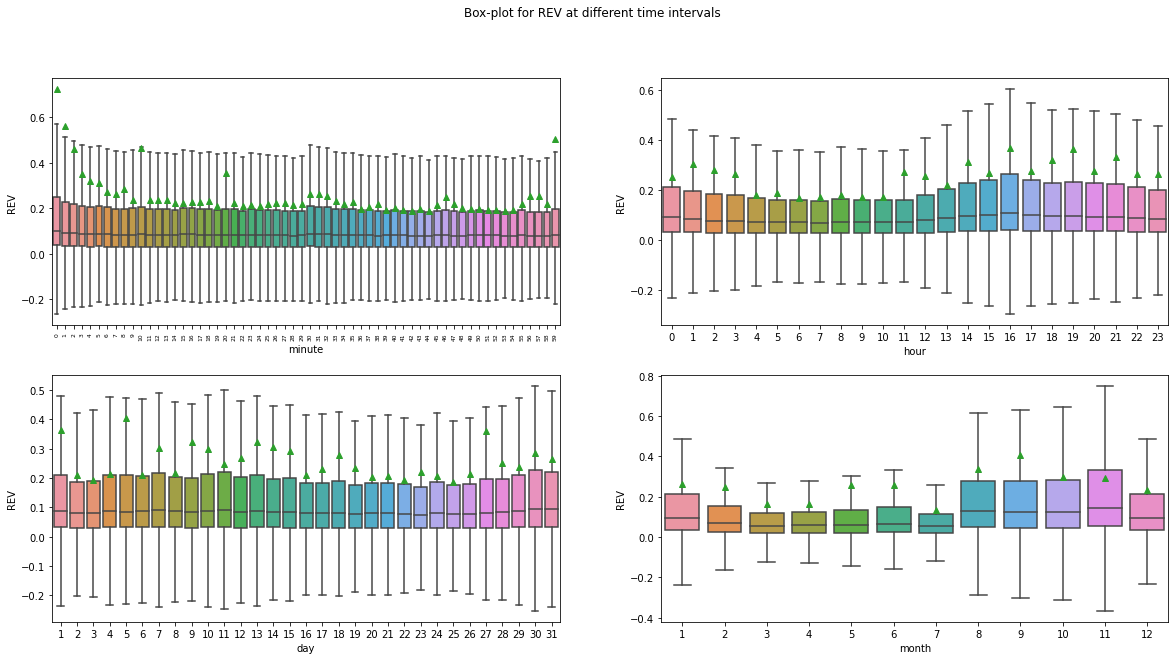

In [19]:
#@title Time effects
plt.subplots(2, 2, figsize = (20, 10))
plt.suptitle('Box-plot for REV at different time intervals')
plt.subplot(2, 2, 1) 
sns.boxplot(x='minute', y="block_net_profit", data=rev_data, showmeans=True, showfliers=False)
plt.xticks(rotation=90, fontsize=6)
plt.ylabel('REV')
plt.subplot(2, 2, 2) 
sns.boxplot(x='hour', y="block_net_profit", data=rev_data, showmeans=True, showfliers=False)
plt.ylabel('REV')
plt.subplot(2, 2, 3) 
sns.boxplot(x='day', y="block_net_profit", data=rev_data, showmeans=True, showfliers=False)
plt.ylabel('REV')
plt.subplot(2, 2, 4) 
sns.boxplot(x='month', y="block_net_profit", data=rev_data, showmeans=True, showfliers=False)
plt.ylabel('REV')


## 3. Decision Tree Classifier
In this model, the original block level data is aggregated to hourly data by taking the median REV across all blocks within the hour.

Using hourly data not only saves computational time, but also removes the outliers by taking the median. Although outliers are not too much of an issue in Decision Tree, in other models it might cause significant bias.

The target variable REV will be modelled as different classes through dividing block net profit into equal size bins. 

The reason to create equal size bins is to avoid the problem of predicting the most frequent class. Due to the uneven distribution of REV and the high concentration in the lower REV, if the bin size is not equal, a classifier can simply predict the most frequent class and achieve a high accuracy without any effort.

The equal size bins ensure all the classes have the equal number of observations and the model has to provide enough discriminatory power to be able to distinguish each class.

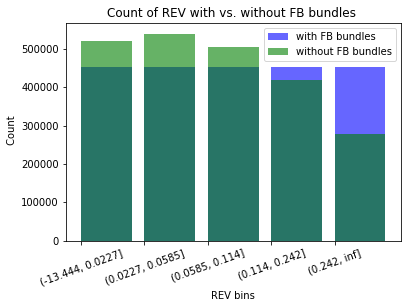

In [25]:
#@title Create equal-frequency bins 
n, mybins, patches = plt.hist(rev_data.block_net_profit, equalbins(rev_data.block_net_profit, 5), edgecolor='black')
# model_bins = [-np.inf, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.13, 0.16, np.inf]
model_bins = np.append(mybins[:-1], np.inf)

## Create block net profit buckets
model_data = rev_data
model_data['profit_bin'] = pd.cut(model_data['block_net_profit'], right=True, bins=model_bins).astype(str)
model_data['profit_bin_value'] = pd.cut(model_data['block_net_profit'], right=True, bins=model_bins).cat.codes

model_data['profit_non_FB_bin'] = pd.cut(model_data['profit_no_bundles'], right=True, bins=model_bins).astype(str)
model_data['profit_non_FB_bin_value'] = pd.cut(model_data['profit_no_bundles'], right=True, bins=model_bins).cat.codes

## Plot with equal bin count for modeling
profit_agg = aggregate_profit(model_data, 'profit_bin', 'block_net_profit')[:-1]
profit_agg_nfb = aggregate_profit(model_data, 'profit_non_FB_bin', 'block_net_profit')[:-1]
plt.close()

plt.plot(figsize=(25,8))
plt.bar(profit_agg["profit_bin"], profit_agg["count"], color = 'b', label='with FB bundles', alpha=0.6, align='edge')
plt.bar(profit_agg_nfb['profit_non_FB_bin'], profit_agg_nfb["count"], color = 'g', label='without FB bundles', alpha=0.6, align='edge')
plt.xlabel("REV bins")
plt.ylabel(" Count")
plt.title("Count of REV with vs. without FB bundles ")
plt.xticks(rotation = 20)
plt.legend()


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

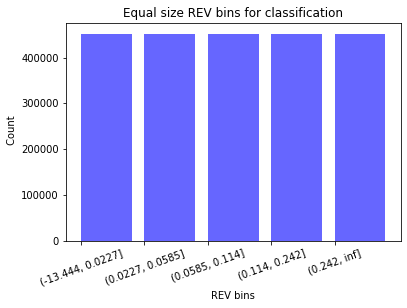

In [26]:
plt.plot(figsize=(25,8))
plt.bar(profit_agg["profit_bin"], profit_agg["count"], color = 'b', label='with FB bundles', alpha=0.6, align='edge')
plt.xlabel("REV bins")
plt.ylabel(" Count")
plt.title("Equal size REV bins for classification")
plt.xticks(rotation = 20)


The data is split randomly into 75% training and 25% testing. The initial model is trained on the training set and attempts to find the optimal hyper-parameters, such as the maximum tree depth, the minimum sample leaf etc. to ensure the training set is not overfitted.


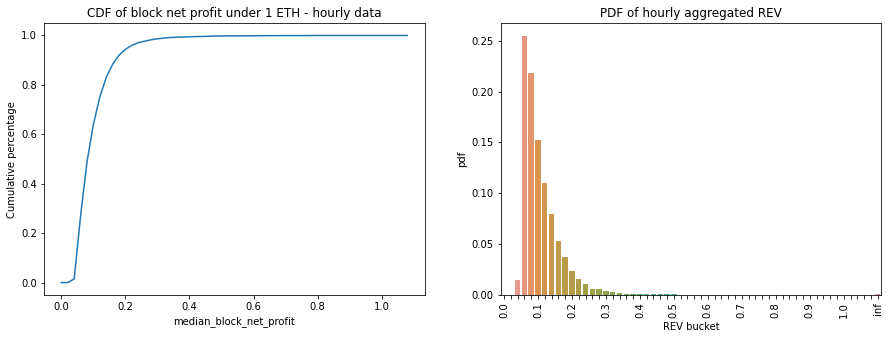

In [21]:
#@title Initial Model
data_h = aggregate_to_hour(rev_data)


## Plot profit <= 1ETH
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1) 
freq_table_h = plot_cdf(data=data_h, var='median_block_net_profit', lb=0, ub=1.1, increment=0.02, title='CDF of block net profit under 1 ETH - hourly data')
plt.subplot(1, 2, 2) 
sns_bar_plot(freq_table_h, 'bin', 'pdf', 5, 'PDF of hourly aggregated REV')
plt.xlabel('REV bucket')
plt.show()


In [ ]:
#create histogram with equal-frequency bins 
n, mybins, patches = plt.hist(data_h.median_block_net_profit, equalbins(data_h.median_block_net_profit, 5), edgecolor='black')
# model_bins = [-np.inf, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.13, 0.16, np.inf]
model_bins = np.append(mybins[:-1], np.inf)

## Create block net profit buckets
data_h['profit_bin'] = pd.cut(data_h['median_block_net_profit'], right=True, bins=model_bins).astype(str)
data_h['profit_bin_value'] = pd.cut(data_h['median_block_net_profit'], right=True, bins=model_bins).cat.codes
# data_h['profit_bin_0.05'] = pd.cut(data_h['median_block_net_profit'], right=True, bins=freq_table_h['bin']).astype(str)

data_h['profit_non_FB_bin'] = pd.cut(data_h['median_profit_no_bundles'], right=True, bins=model_bins).astype(str)
data_h['profit_non_FB_bin_value'] = pd.cut(data_h['median_profit_no_bundles'], right=True, bins=model_bins).cat.codes
# data_h['profit_non_FB_bin_0.05'] = pd.cut(data_h['median_profit_no_bundles'], right=True, bins=freq_table_h['bin']).astype(str)

## Create t+1 block net profit and bin
data_h['median_block_net_profit_t_1'] = data_h['median_block_net_profit'].shift(-1)
data_h['profit_bin_t_1'] = data_h['profit_bin'].shift(-1)
data_h['profit_non_FB_bin_t_1'] = data_h['profit_non_FB_bin'].shift(-1)

## Plot with equal bin count for modeling
profit_agg_h = aggregate_profit(data_h, 'profit_bin_t_1', 'median_block_net_profit_t_1')
profit_agg_nfb_h = aggregate_profit(data_h, 'profit_non_FB_bin_t_1', 'median_block_net_profit_t_1')

plt.close()


In [ ]:
#####################
## Data Prep Split ##
#####################
## Create target variables
data_h = data_h[data_h['profit_bin']!='nan']
x = data_h[['median_block_time', 'median_eth_usd_price','median_tail_gas_price', 'median_total_gas_used','median_base_fee_per_gas']]
y = data_h[['profit_bin']]
# y_p = pd.DataFrame(x[["profit_bin"]].value_counts(dropna=False)/len(x[["profit_bin"]])).reset_index().rename(columns={0:"y_p"})
# y = y.merge(y_p, on='profit_bin', how='left')

## Split training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)


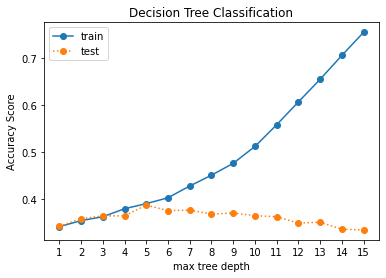

In [14]:
#############################
## DT Initial Hourly Model ##
#############################
## Testing max_depths
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
dt_table = pd.DataFrame(columns=['max_depth','accuracy_train', 'accuracy_test', 'log_loss_train', 'log_loss_test'])

for d in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy',
                                max_depth=d, 
                                # min_samples_leaf=10,
                                random_state=123,
                                ).fit(x_train, y_train)
    dt_pred_train = dt.predict(x_train)
    dt_pred_test = dt.predict(x_test)
    dt_pred_p_train = dt.predict_proba(x_train)
    dt_pred_p_test = dt.predict_proba(x_test)
    
    accuracy_train = accuracy_score(y_train, dt_pred_train)
    accuracy_test = accuracy_score(y_test, dt_pred_test)
    
    dt_table = dt_table.append({'max_depth':d, 
                                'accuracy_train':accuracy_train,
                                'accuracy_test':accuracy_test},
                               ignore_index=True)
    

plt.plot(dt_table['max_depth'], dt_table['accuracy_train'], label = "train", marker = "o")
plt.plot(dt_table['max_depth'], dt_table['accuracy_test'], label = "test", linestyle = ":",  marker = "o")
plt.xticks(np.arange(min(dt_table['max_depth']), max(dt_table['max_depth'])+1,1))
plt.xlabel('max tree depth')
plt.ylabel('Accuracy Score')
plt.title('Decision Tree Classification')
plt.legend()
plt.show()



With different trials of maximum tree depths, the optimal point is found at 5 where the accuracy between the training set and testing set starts to diverge. 

The final model has an accuracy score of 39% from both the training and the testing set. There is very little overfitting in the model given the similar model performance from both sets.

The model performance is not very good using Decision Tree Classifier. There are quite a lot of mis-classification in each of the class.

The balance accuracy of the training & testing set are:
0.3898
0.3867
The precision, recall, fscore of the training & testing set are:
(0.39682267065420895, 0.38984898022730813, 0.3871719456517078, None)
(0.39609912881921844, 0.3867351704810836, 0.3868451780019191, None)


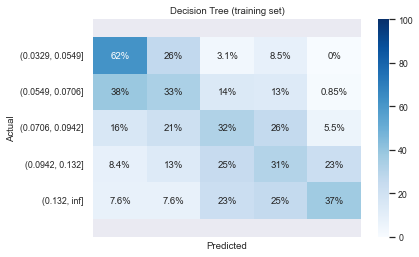

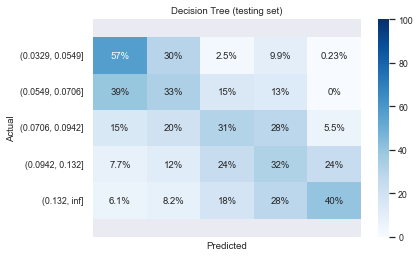

In [15]:
###############################
## Decision Tree Final Model ##
###############################
dt = DecisionTreeClassifier(criterion='entropy', 
                            max_depth=5, 
                            random_state=123,
                            ).fit(x_train, y_train)
dt_pred_train = dt.predict(x_train)
dt_pred_test = dt.predict(x_test)
dt_pred_p_train = dt.predict_proba(x_train)
dt_pred_p_test = dt.predict_proba(x_test)

## Performance
print("The balance accuracy of the training & testing set are:")
print(np.round(accuracy_score(y_train, dt_pred_train),4))
print(np.round(accuracy_score(y_test, dt_pred_test),4))

print("The precision, recall, fscore of the training & testing set are:")
print(precision_recall_fscore_support(y_train, dt_pred_train, average='weighted'))
print(precision_recall_fscore_support(y_test, dt_pred_test, average='weighted'))

## Confusion matrix
## Training set

plot_confusion_matrix(y_train, dt_pred_train, class_name=np.unique(y_train), fontsize=0.8,
                      title = 'Decision Tree (training set)'
)

## Validation set
plot_confusion_matrix(y_test, dt_pred_test, class_name=np.unique(y_train), fontsize=0.8,
                      title = 'Decision Tree (testing set)'
)


## 4. Random Forest Regressor
In the attempt to improve model performance, a Random Forest Regressor model is used here. Random Forest is similar to Decision Tree, except that it uses ensemble method to create sub-samples to build many decision trees to train the model better. Instead of predicting the class, the regressor will predict a continuous REV to see if this approach improves the results.

The optimal maximum tree depth is 4 based on the R-squared plot below. Tree depths larger than 4 overfits the training set and does not add much value to the teseting set.


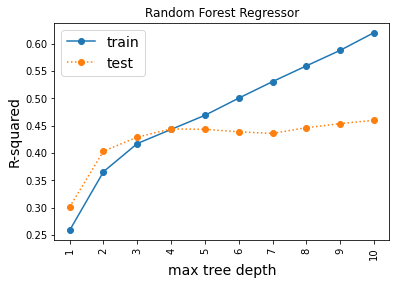

In [27]:
################################
## Random Forest Hourly Model ##
################################
x = data_h[['median_block_time', 'median_eth_usd_price','median_tail_gas_price', 'median_total_gas_used','median_base_fee_per_gas']]
y = data_h[['median_block_net_profit']]

## Split training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

#############################
## RF Initial Hourly Model ##
#############################
n_estimators = [50,100,150,200,250,300]
max_depths = [1,2,3,4,5,6,7,8,9,10]


rf_table = pd.DataFrame(columns=['max_depth','balanced_accuracy_train', 'balanced_accuracy_test', 'log_loss_train', 'log_loss_test'])
for d in max_depths:
    rf = RandomForestRegressor(max_depth=d,
                               # n_estimators=d,
                               random_state=123,
                               ).fit(x_train, y_train)
    rf_pred_train = rf.predict(x_train)
    rf_pred_test = rf.predict(x_test)

    accuracy_train = rf.score(x_train, y_train)
    accuracy_test = rf.score(x_test, y_test)

    
    rf_table = rf_table.append({'max_depth':d, 
                                'r_squared_train':accuracy_train,
                                'r_squared_test':accuracy_test,},
    ignore_index=True)
    
rf_max_depth = rf_table
plt.plot(rf_table['max_depth'], rf_table['r_squared_train'], label = "train", marker = "o")
plt.plot(rf_table['max_depth'], rf_table['r_squared_test'], label = "test", linestyle = ":",  marker = "o")
plt.xticks(max_depths, rotation=90)
plt.xlabel('max tree depth',fontsize=14)
plt.ylabel('R-squared', fontsize=14)
plt.legend(fontsize=14)
plt.title("Random Forest Regressor")
plt.show()

The final model's R-squared is 44% for both the training and the testing set. Although 83% of the actual REV fall into the 2.5% and 97.5% prediction confidence interval, the performance is still not great and there are quite a lot of under-predictions clustered in REV <= 0.5 ETH.

The R-squared for Random Forest Regression training set is: 0.444
The R-squared for Random Forest Regression testing set is: 0.439


Text(0.5, 1.0, 'Predicted vs. actual REV (log-scale)')

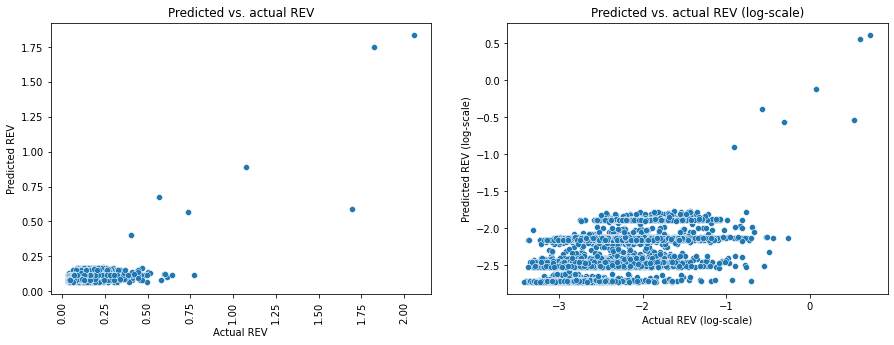

In [29]:
###########################
## RF Final Hourly Model ##
###########################
rf_final = RandomForestRegressor(max_depth=4, n_estimators=500, random_state=123).fit(x_train, y_train)      

print('The R-squared for Random Forest Regression training set is: {:.3f}'.format(rf_final.score(x_train, y_train)))
print('The R-squared for Random Forest Regression testing set is: {:.3f}'.format(rf_final.score(x_test, y_test)))
## Scatter plot actual vs. predicted
f, axs = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=(y_train['median_block_net_profit']), y=(rf_final.predict(x_train)))
plt.xlabel("Actual REV")
plt.ylabel("Predicted REV")
plt.title("Predicted vs. actual REV")
plt.xticks(rotation=90)
## Scatter plot (log-scale) actual vs. predicted sale price for August 
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.log(y_train['median_block_net_profit']), y=np.log(rf_final.predict(x_train)))
plt.xlabel("Actual REV (log-scale)")
plt.ylabel("Predicted REV (log-scale)")
plt.title("Predicted vs. actual REV (log-scale)")


Text(0.5, 1.0, 'Predicted vs. actual REV (log-transformed) - testing set ')

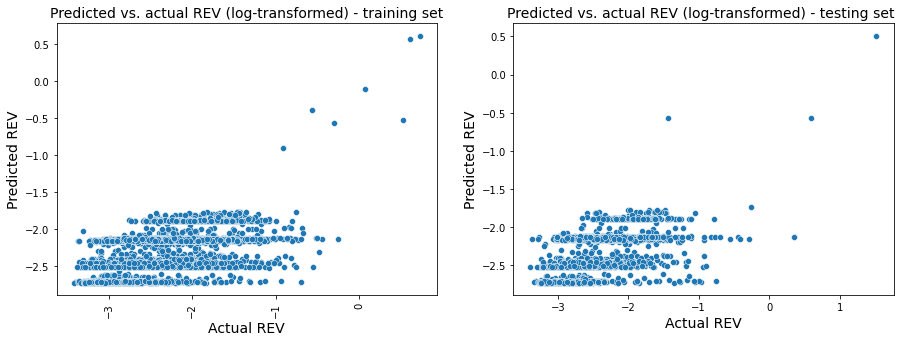

In [31]:
## Scatter plot actual vs. predicted
## Training set
f, axs = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=np.log(y_train['median_block_net_profit']), y=np.log(rf_final.predict(x_train)))
plt.xlabel("Actual REV", fontsize=14)
plt.ylabel("Predicted REV", fontsize=14)
plt.title("Predicted vs. actual REV (log-transformed) - training set", fontsize=14)
plt.xticks(rotation=90)
## Testing set
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.log(y_test['median_block_net_profit']), y=np.log(rf_final.predict(x_test)))
plt.xlabel("Actual REV", fontsize=14)
plt.ylabel("Predicted REV", fontsize=14)
plt.title("Predicted vs. actual REV (log-transformed) - testing set ", fontsize=14)


The percentage of actual REV inside the conf. intervals is:  0.8247518972562755


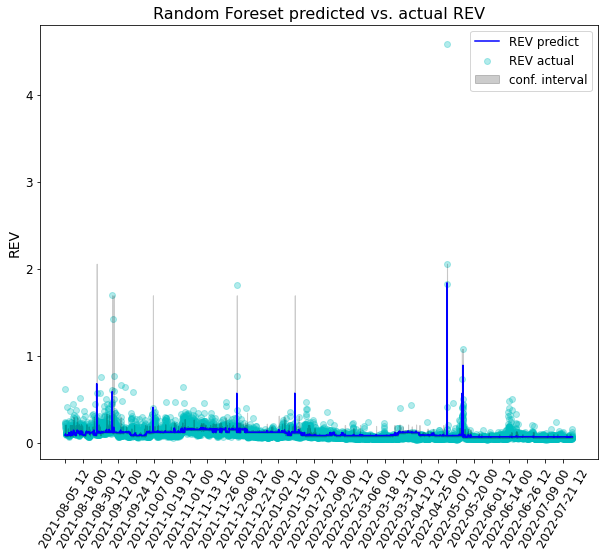

In [41]:
##########################
## RF Prediction Output ##
##########################
## Assign predictions 
y_train['predict'] = rf_final.predict(x_train)
y_test['predict'] = rf_final.predict(x_test)

## Create confidence intervals
train_int = pd.DataFrame(index=y_train.index)
test_int = pd.DataFrame(index=y_test.index)

for i in range(0, len(rf_final), 1):
    pred_train = pd.DataFrame(rf_final.estimators_[i].predict(x_train), index=y_train.index).rename(columns={0:"estimator"+str(i)})
    train_int = pd.concat([train_int, pred_train], axis=1)
    
    pred_test = pd.DataFrame(rf_final.estimators_[i].predict(x_test), index=y_test.index).rename(columns={0:"estimator"+str(i)})
    test_int = pd.concat([test_int, pred_test], axis=1)

y_train['predict_lb'] = train_int.apply(lambda x: x.quantile(0.025), axis=1)
y_train['predict_ub'] = train_int.apply(lambda x: x.quantile(0.975), axis=1)

y_test['predict_lb'] = test_int.apply(lambda x: x.quantile(0.025), axis=1)
y_test['predict_ub'] = test_int.apply(lambda x: x.quantile(0.975), axis=1)

output = pd.concat([y_train, y_test], axis=0).sort_index(ascending = True)
output = pd.merge(data_h['datetime_h'], output, how='left', left_index=True, right_index=True)

output['is_in_ci'] = (output['median_block_net_profit']<=output['predict_ub']) & (output['median_block_net_profit']>=output['predict_lb'])
print("The percentage of actual REV inside the conf. intervals is: ", output['is_in_ci'].value_counts(dropna=False)[0]/len(output))

## Plot realised total reward by hour
plt.figure(figsize=(10,8))
plt.plot(output['datetime_h'], output['predict'], color = 'b', label='REV predict')
plt.scatter(output['datetime_h'], output['median_block_net_profit'], color = 'c',label='REV actual', alpha=0.3)
plt.fill_between(output['datetime_h'], output['predict_lb'], output['predict_ub'], color='k', alpha=0.2, label='conf. interval')
plt.ylabel("REV", fontsize=14)
plt.xticks(np.arange(0, len(output), 300), fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation = 60)
plt.title("Random Foreset predicted vs. actual REV", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')
#output.to_csv('Data/rev_randomforest.csv') ## this file feeds into eth2-mev-update.ipynb

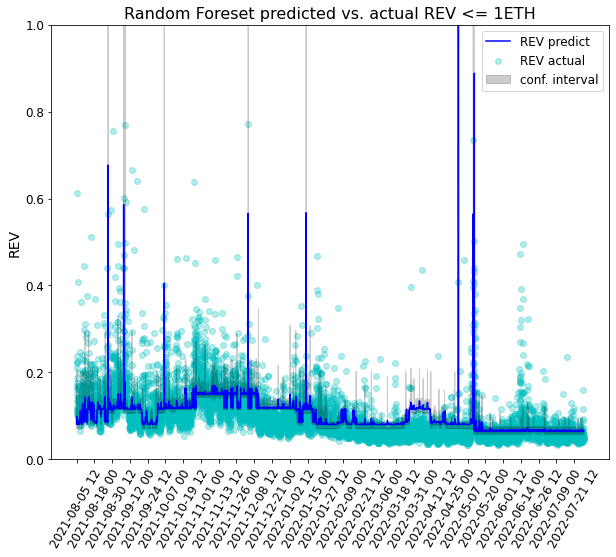

In [45]:
## Plot realised total reward by hour
plt.figure(figsize=(10,8))
plt.plot(output['datetime_h'], output['predict'], color = 'b', label='REV predict')
plt.scatter(output['datetime_h'], output['median_block_net_profit'], color = 'c',label='REV actual', alpha=0.3)
plt.fill_between(output['datetime_h'], output['predict_lb'], output['predict_ub'], color='k', alpha=0.2, label='conf. interval')
plt.ylabel("REV", fontsize=14)
plt.xticks(np.arange(0, len(output), 300), fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation = 60)
plt.ylim(0,1)
plt.title("Random Foreset predicted vs. actual REV <= 1ETH", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')